In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import json

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import glob

from io import BytesIO

from diffusers import AutoPipelineForText2Image
import diffusers
import torch

diffusers.logging.set_verbosity_error()

In [2]:
from diffusers.utils import make_image_grid, load_image
from PIL import Image
from matplotlib import pyplot

In [3]:
ROOT = '../kcg-ml-image-pipeline/output/dataset/'
DATASET_NAME = 'environmental'

In [2]:
pipeline = AutoPipelineForText2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16", local_files_only=True
)
pipeline.set_progress_bar_config(disable=True)

pipeline.safety_checker = None
pipeline.requires_safety_checker = False

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


# check reconstruction

In [ ]:
pipeline = pipeline.to("cuda")

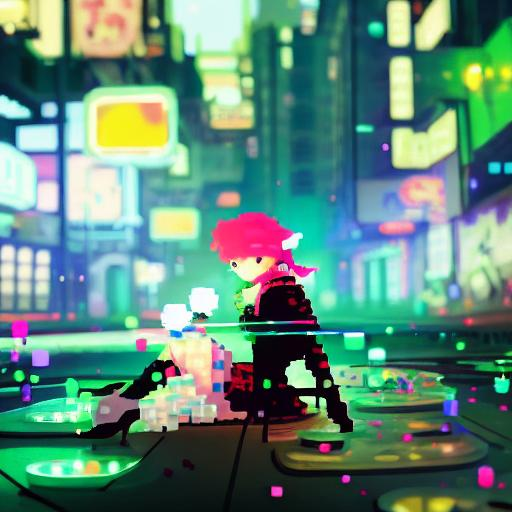

In [4]:
img = Image.open(os.path.join(ROOT, 'image', DATASET_NAME, '0001/000000.jpg'))
img

In [5]:
image = pipeline.image_processor.preprocess(img)
latent = pipeline.vae.encode(image.half().cuda()).latent_dist.mean
latent.shape

torch.Size([1, 4, 64, 64])

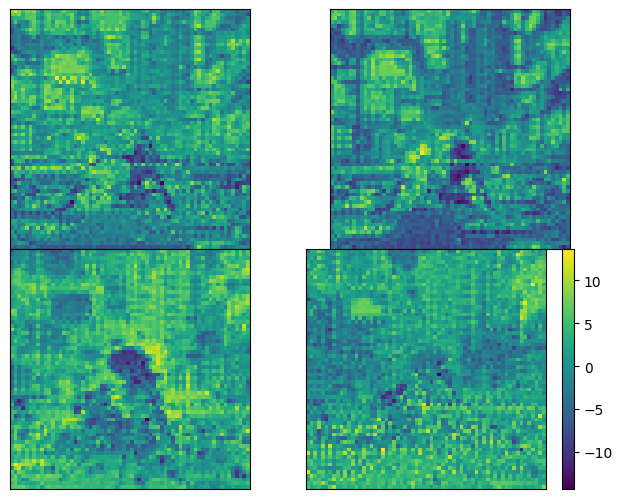

In [6]:
pyplot.subplot(2, 2, 1)

pyplot.imshow(latent[0,0].detach().cpu().numpy())
pyplot.gca().set_xticks([])
pyplot.gca().set_yticks([])

pyplot.subplot(2, 2, 2)

pyplot.imshow(latent[0,1].detach().cpu().numpy())
pyplot.gca().set_xticks([])
pyplot.gca().set_yticks([])

pyplot.subplot(2, 2, 3)

pyplot.imshow(latent[0,2].detach().cpu().numpy())
pyplot.gca().set_xticks([])
pyplot.gca().set_yticks([])

pyplot.subplot(2, 2, 4)

pyplot.imshow(latent[0,3].detach().cpu().numpy())
pyplot.gca().set_xticks([])
pyplot.gca().set_yticks([])

pyplot.subplots_adjust(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
pyplot.colorbar()

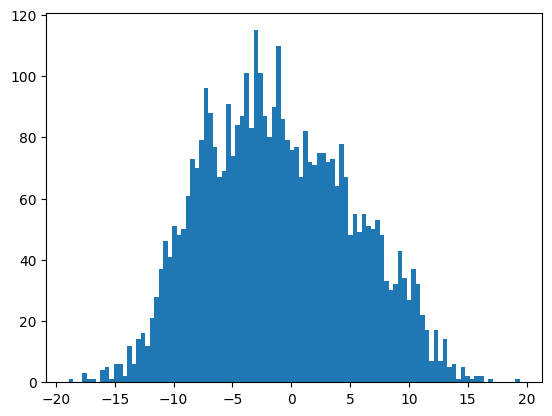

In [7]:
_ = pyplot.hist(latent[0,1].detach().cpu().numpy().reshape((-1)), bins=100)

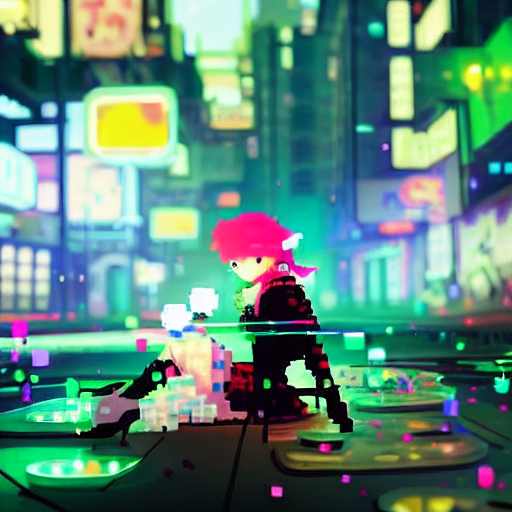

In [8]:
image = pipeline.vae.decode(latent)[0]
image = pipeline.image_processor.postprocess(image.detach(), output_type='pil', do_denormalize=[True])[0]
image

In [9]:
np.abs(np.asarray(img).astype(float) - np.asarray(image).astype(float)).mean()

5.140638987223308

# train simple linear

## make dataset

In [5]:
BATCH_SIZE = 64

NUM_SAMPLES = 8192

In [6]:
file_paths = glob.glob(os.path.join(ROOT, 'image', DATASET_NAME, '**/*.jpg'))

if NUM_SAMPLES > 0 and len(file_paths) > NUM_SAMPLES:
    file_paths = np.random.choice(file_paths, NUM_SAMPLES, False)

In [12]:
image_processor = pipeline.image_processor
vae = pipeline.vae
vae.encoder = vae.encoder.to('cuda')
vae.quant_conv = vae.quant_conv.to('cuda')

In [13]:
xs = list()
ys = list()

for i in tqdm(range(0, len(file_paths), BATCH_SIZE), leave=False):

    images = list()

    for file_path in file_paths[i:i+BATCH_SIZE]:

        image = Image.open(file_path).convert('RGB')

        images.append(image)
        
        y = np.array(image.resize((64, 64))) / 256.

        ys.append(y)
    
    with torch.no_grad():
        images = image_processor.preprocess(images)
        latent = vae.encode(images.half().cuda()).latent_dist.mean

    xs.append(latent.detach().cpu().numpy())

xs = np.concatenate(xs, axis=0)
ys = np.stack(ys, axis=0).transpose(0, 3, 1, 2)

  0%|          | 0/128 [00:00<?, ?it/s]

In [21]:
np.savez(
    os.path.join('data', DATASET_NAME, 'vae.npz'),
    file_paths=np.array([i[46:] for i in file_paths]),
    xs=xs,
    ys=ys
)

## train

In [4]:
BATCH_SIZE = 64

In [5]:
npz = np.load(os.path.join('data', DATASET_NAME, 'vae.npz'))

xs = npz['xs']
ys = npz['ys']

In [6]:
dataset = torch.utils.data.TensorDataset(torch.tensor(xs), torch.tensor(ys))

In [7]:
train_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.2))

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, pin_memory=True)

In [9]:
model = torch.nn.Conv2d(in_channels=4, out_channels=3, kernel_size=(1,1))

In [17]:
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)

In [ ]:
model.train()

mses, l1s, val_mses = list(), list(), list()

for epoch in tqdm(range(100)):
    
    for x, y in train_dataloader:
    
        optimizer.zero_grad()
    
        pred = model(x.float())
    
        # backward
    
        mse = torch.nn.functional.mse_loss(y.float(), pred)
        l1 = torch.nn.functional.l1_loss(y.float(), pred)
    
        loss = mse + l1
    
        loss.backward()
        optimizer.step()

        mses.append(mse.detach().cpu().numpy())
        l1s.append(l1.detach().cpu().numpy())

    
    for x, y in val_dataloader:
    
        pred = model(x.float())
    
        # backward
    
        mse = torch.nn.functional.mse_loss(y.float(), pred)
        
        val_mses.append(mse.detach().cpu().numpy())
        
    print(f'{np.mean(mses):.4f} {np.mean(l1s):.4f} {np.mean(val_mses):.4f}')

    mses, l1s, val_mses = list(), list(), list()

In [12]:
print(f'{np.mean(mses):.4f} {np.mean(l1s):.4f}')

0.0132 0.0879


In [21]:
import torchvision

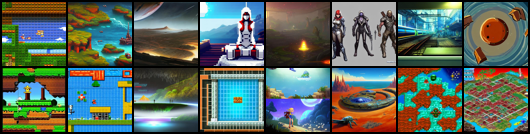

In [22]:
torchvision.transforms.functional.to_pil_image(torchvision.utils.make_grid(y[:16], ncol=2))

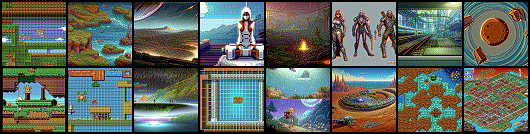

In [23]:
torchvision.transforms.functional.to_pil_image(torchvision.utils.make_grid(torch.clip(pred[:16], 0, 1 - 1e-4), ncol=2))

In [27]:
delta = y[:16] - pred[:16]
delta = torchvision.utils.make_grid(delta, ncol=2)
delta = delta.detach().cpu().numpy()

In [31]:
r, g, b = delta.tolist()

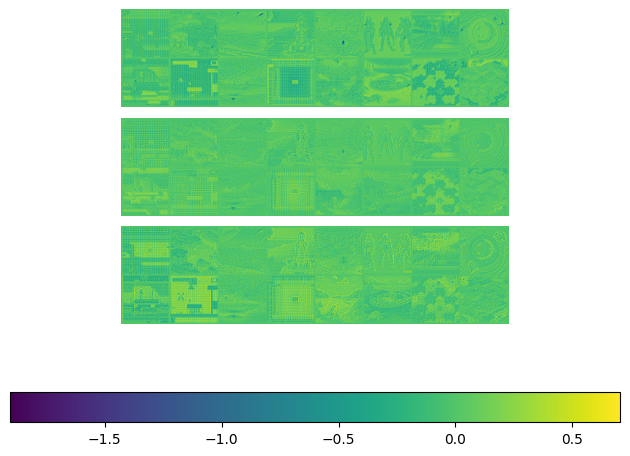

In [46]:
fig, axs = pyplot.subplots(3, 1)

cmap = 'viridis'
norm = pyplot.Normalize(delta.min(), delta.max())

im1 = axs[0].imshow(r, cmap=cmap, norm=norm)
axs[0].axis('off')

axs[1].imshow(g, cmap=cmap, norm=norm)
axs[1].axis('off')

axs[2].imshow(b, cmap=cmap, norm=norm)
axs[2].axis('off')

pyplot.tight_layout()

fig.colorbar(im1, ax=axs, orientation='horizontal')

In [14]:
model.weight.shape

torch.Size([3, 4, 1, 1])

In [15]:
model.weight[..., 0, 0]

tensor([[ 0.0291,  0.0148, -0.0189, -0.0182],
        [ 0.0209,  0.0281,  0.0184, -0.0253],
        [ 0.0255,  0.0089,  0.0221, -0.0540]], grad_fn=<SelectBackward0>)